In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import matplotlib.pyplot as plt
from pandas_ml_common import Constant
from pandas_ml_utils import FeaturesAndLabels, Model, SkModel
from pandas_ml_utils.ml.data.extraction import extract_with_post_processor
from pandas_ml_quant import pd, np, PostProcessedFeaturesAndLabels

# make experiments reproducable
import torch as t
t.manual_seed(0)

automatically imported pandas_ml_utils 0.1.4


In [ ]:
df = pd.fetch_yahoo("QQQ")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-04-20,213.36,215.88,212.57,212.74,38249100.0,0.0,0.0
2020-04-21,210.60,211.16,203.63,204.89,72932800.0,0.0,0.0
2020-04-22,209.10,212.35,208.33,210.97,40188800.0,0.0,0.0
2020-04-23,211.79,214.44,210.10,210.52,43278500.0,0.0,0.0
2020-04-24,210.94,214.27,209.50,213.84,32753396.0,0.0,0.0


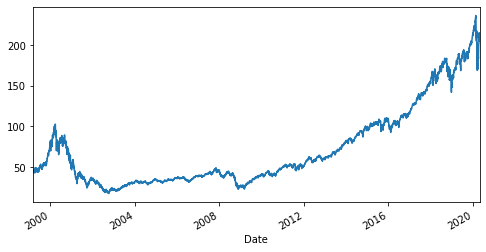

In [10]:
df["Close"].plot(figsize=(8, 4))
df.tail()

In [11]:
from sklearn.neural_network import MLPClassifier
from pandas_ml_utils.ml.data.splitting import RandomSplits
from pandas_ml_utils.ml.summary import ClassificationSummary
from pandas_ml_utils.ml.data.splitting.sampeling import KEquallyWeightEvents

fit = df.model.fit(
    SkModel(
        MLPClassifier(
            activation='tanh', 
            hidden_layer_sizes=(60, 50), 
            random_state=42, 
            max_iter=300
        ),
        FeaturesAndLabels(
            features=[lambda df: df["Close"].ta.log_returns().ta.rnn(200)],
            labels=[lambda df:\
                df["Close"].shift(-7) > df["Close"].ta.sma(20)]
        ),
        summary_provider=ClassificationSummary
    ),
    RandomSplits(
        test_size=0.4,
        test_validate_split_seed=42,
        cross_validation=(1, KEquallyWeightEvents(n_splits=3).split)
    )
)

fit

(3070, 2) (3070, 2)
(2047, 2) (2047, 2)


In [14]:
from sklearn.neural_network import MLPClassifier
from pandas_ml_utils.ml.data.splitting import RandomSplits
from pandas_ml_utils.ml.summary import ClassificationSummary, BinaryClassificationSummary
from pandas_ml_utils.ml.data.splitting.sampeling import KEquallyWeightEvents

fit = df.model.fit(
    SkModel(
        MLPClassifier(
            activation='tanh', 
            hidden_layer_sizes=(60, 50), 
            random_state=42, 
            max_iter=100
        ),
        FeaturesAndLabels(
            features=[lambda df:\
                  df["Close"].ta.macd().ta.rnn(200)],
            labels=[lambda df:\
                  df["Close"].shift(-7) > df["Close"].ta.sma(20)],
        ),
        summary_provider=ClassificationSummary
    ),
    RandomSplits(
        test_size=0.4,
        test_validate_split_seed=42,
        cross_validation=(1, KEquallyWeightEvents(n_splits=3).split)
    )
)

fit

  % self.max_iter, ConvergenceWarning)

  % self.max_iter, ConvergenceWarning)

  % self.max_iter, ConvergenceWarning)



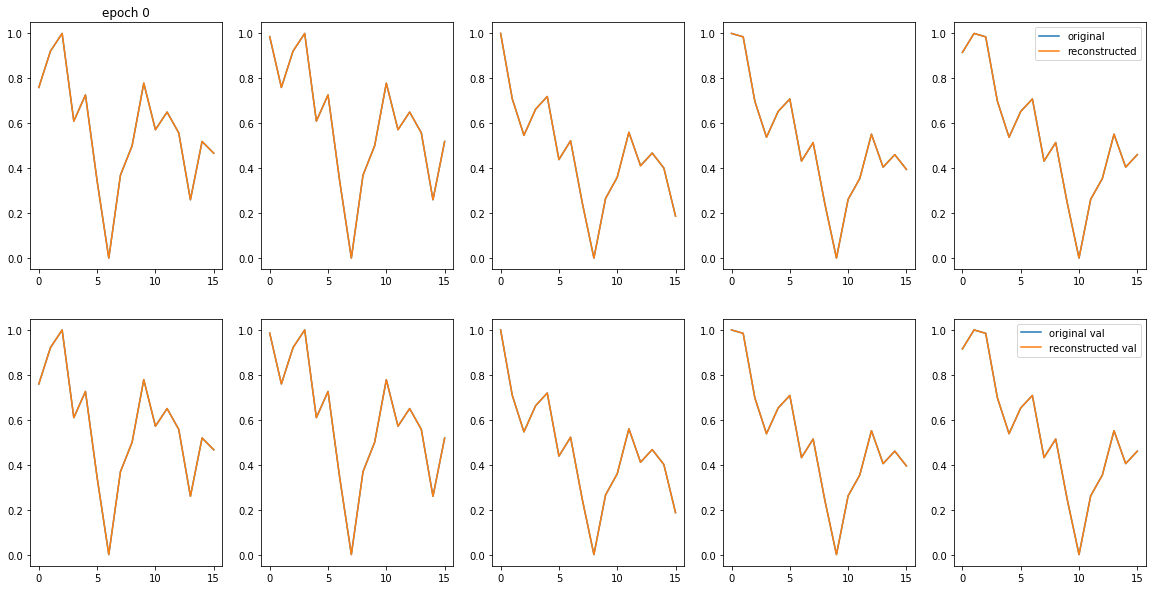

,Close_gaf
Date,
2020-04-20,"[[0.7026782867467336, 0.9226804123711345, 0.73..."
2020-04-21,"[[-0.06248857660761453, 0.3506946218504324, 0...."
2020-04-22,"[[0.5103620512054832, 0.23433864619137323, 0.6..."
2020-04-23,"[[0.4633050296759984, 0.48701028791038087, 0.2..."
2020-04-24,"[[0.8224227941407416, 0.6552299602313036, 0.67..."


In [16]:
from IPython.display import clear_output

def inverse_gaf(values):
    values = values[0] # use first channel
    return np.sqrt(((np.diag(values) + 1) / 2))
    
def plot_callback(y, y_hat, y_val, y_hat_val, epoch):
    clear_output(wait=True)
    fig, ax = plt.subplots(2, 5, figsize=(20, 10))    
    ax[0, 0].set_title(f'epoch {epoch}')

    for i in range(5):
        _y = inverse_gaf(y[i])
        _y_hat = inverse_gaf(y_hat[i])

        _y_val = inverse_gaf(y_val[i])
        _y_hat_val = inverse_gaf(y_hat_val[i])
        
        ax[0, i].plot(_y, label="original")
        ax[0, i].plot(_y_hat, label="reconstructed")
        ax[1, i].plot(_y_val, label="original val")
        ax[1, i].plot(_y_hat_val, label="reconstructed val")
        
    ax[0, -1].legend()
    ax[1, -1].legend()
    plt.show()
            
f_n_l = FeaturesAndLabels(
    [lambda df: df["Close"].ta.rnn(16).ta.gaf(type='invertible', rescale=True)],
    [lambda df: df["Close"].ta.rnn(16).ta.gaf(type='invertible', rescale=True)],
    targets = [lambda df: df["Close"] > df["Close"].shift(16)]
)

(f, _), l, t, w = df._.extract(f_n_l)
label = l._.values

# plot and simulate a batch
plot_callback(label[:10], label[:10], label[:10], label[:10], 0)

f.tail()

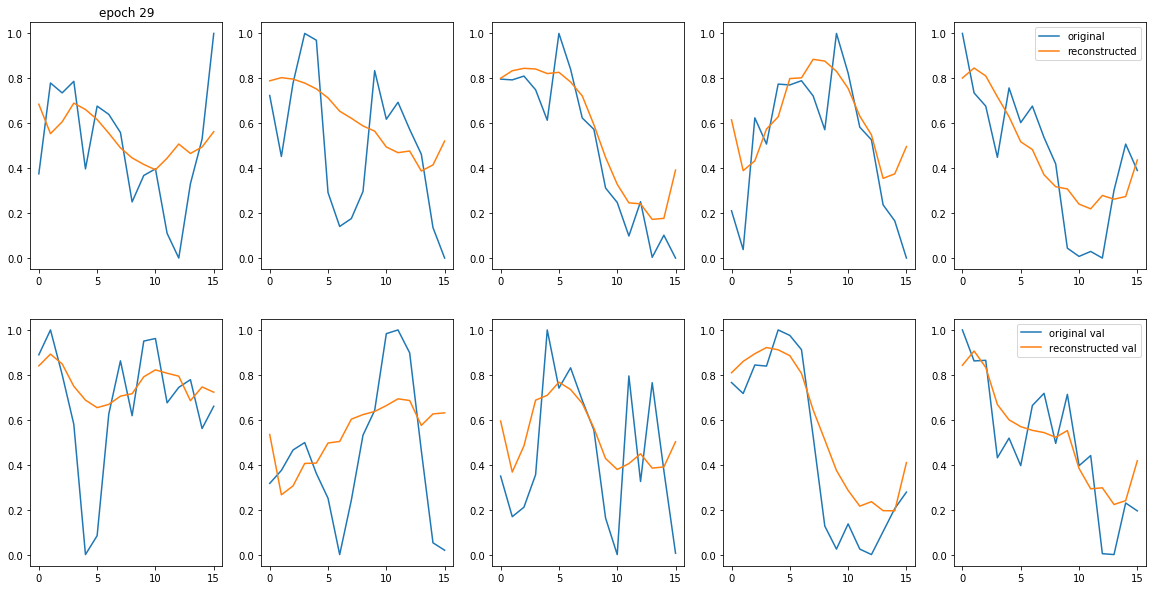

In [34]:
import torch as t
import torch.nn as nn
from torch.optim import Adam, Adagrad, RMSprop
from pandas_ml_utils import FeaturesAndLabels, PytorchModel, AutoEncoderModel
from pandas_ml_utils.pytorch import Reshape

# make experiment reproducable
t.manual_seed(0)

class AutoEncoder(nn.Module):

    def __init__(self):
        super().__init__()
        self._encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Conv2d(4, 1, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            
            nn.Flatten()            
        )
        
        self._decoder = nn.Sequential(            
            Reshape(1, 2, 2),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(1, 4, 3, padding=1),
            nn.ReLU(),
            
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(4, 16, 3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 1, 3, padding=1),
            nn.Tanh()
        )
        
    def forward(self, x):
        _x = x # .view(-1, seq)
        _x = self._encoder(_x)
        _x = self._decoder(_x)
        return _x

    def encoder(self, x):
        with t.no_grad():
            return self._encoder(t.from_numpy(x).float()).numpy()

    def decoder(self, x):
        with t.no_grad():
            return self._decoder(t.from_numpy(x).float()).numpy()



fit = df.model.fit(
    AutoEncoderModel(
        PytorchModel(
            FeaturesAndLabels(
                features=[lambda df:\
                      df["Close"]\
                          .ta.rnn(16)\
                          .ta.gaf(type='invertible', rescale=True)],
                labels=[lambda df:\
                      df["Close"]\
                        .ta.rnn(16)\
                        .ta.gaf(type='invertible', rescale=True)],
            ),
            AutoEncoder,
            nn.MSELoss,
            Adam,
        ),
        # bottleneck of 4 elements
        [f"condensed{i}" for i in range(4)],
        lambda m: m.module.encoder,
        lambda m: m.module.decoder,
    ),
    epochs=30, 
    batch_size=32, 
    on_epoch=[plot_callback]
)

In [35]:
encoder_model = fit.model.as_encoder()
encoded_df = df.model.predict(encoder_model)
encoded_df.tail()

prediction                                   \
           condensed0 condensed1 condensed2 condensed3   
Date                                                     
2020-04-20   0.433004   1.481922   1.076533   2.667575   
2020-04-21   0.583636   1.222356   0.877357   2.621884   
2020-04-22   0.671371   0.976688   0.831406   2.586262   
2020-04-23   0.626449   0.776947   0.923916   2.516512   
2020-04-24   0.487763   0.704816   0.975966   2.307835   

                                                      feature  
                                                    Close_gaf  
Date                                                           
2020-04-20  [[0.7026782867467336, 0.9226804123711345, 0.73...  
2020-04-21  [[-0.06248857660761453, 0.3506946218504324, 0....  
2020-04-22  [[0.5103620512054832, 0.23433864619137323, 0.6...  
2020-04-23  [[0.4633050296759984, 0.48701028791038087, 0.2...  
2020-04-24  [[0.8224227941407416, 0.6552299602313036, 0.67...

In [36]:
from sklearn.neural_network import MLPClassifier
from pandas_ml_utils.ml.data.splitting import RandomSplits
from pandas_ml_utils.ml.summary import ClassificationSummary, BinaryClassificationSummary
from pandas_ml_utils.ml.data.splitting.sampeling import KEquallyWeightEvents

encoder_model = fit.model.as_encoder()
encoded_df = df.model.predict(encoder_model)
encoded_df = encoded_df["prediction"].inner_join(df[["Close"]])

fit = encoded_df.model.fit(
    SkModel(
        MLPClassifier(
            activation='tanh', 
            hidden_layer_sizes=(60, 50), 
            random_state=42, 
            max_iter=100
        ),
        PostProcessedFeaturesAndLabels(
            features=[
                "condensed0", 
                "condensed1", 
                "condensed2", 
                "condensed3"],
            feature_post_processor=[lambda df: df.ta.rnn(200)],
            labels=[lambda df:\
                df["Close"].shift(-7) > df["Close"].ta.sma(20)],
        ),
        summary_provider=ClassificationSummary
    ),
    RandomSplits(
        test_size=0.4,
        test_validate_split_seed=42,
        cross_validation=(1, KEquallyWeightEvents(n_splits=3).split)
    )
)

fit

  % self.max_iter, ConvergenceWarning)

  % self.max_iter, ConvergenceWarning)

  % self.max_iter, ConvergenceWarning)

